In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import extract
import visualize
from sklearn import tree
import pydotplus
import seaborn as sns
import time

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
s0 = pd.read_csv("./data/sale_to_customer_rl_10_price_change_data.csv", usecols = ['d_index_1', 'd_index_2', 'name',
		'cusip', 'state', 'coupon', 'maturity', 'yield', 'issuetype', 'issuesource', 'rtg',
		'tradedate', 'tradedate_2', 'price', 'dprice', 'holdtime'])
#d = extract.get_data("./data/TMC_020617.csv")
#d = extract.clean_data(d)

In [4]:
s0.head()

,dprice,holdtime,d_index_1,d_index_2,tradedate_2,cusip,price,yield,tradedate,name,state,coupon,maturity,issuetype,issuesource,rtg
0,0.476,1.0,0,2676,3.0,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6
1,0.488,2.0,0,2677,4.0,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6
2,3.239,8.0,0,8287,10.0,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6
3,3.089,9.0,0,9511,11.0,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6
4,3.476,9.0,0,9512,11.0,45471AKG6,99.507,4.037,2.0,indiana st fin auth-a,Indiana,4.0,6692.0,ISSUE TYPE: REVENUE BONDS,"ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.",6


In [5]:
#print s0[(s0.cusip == '45471AKG6')&(s0.tradedate == 2.0)]

In [6]:
d_index_1 = s0.pop('d_index_1')
d_index_2 = s0.pop('d_index_2')

In [7]:
s_name_features = extract.build_name_features(s0, num_general_words = 50, num_long_words = 100, long_word_length = 5)
s_state_features = extract.build_state_features(s0, num_states = None)
s_other_features = extract.build_other_text_features(s0, tradetype=False)
s = pd.concat([s0.drop(['state', 'name', 'issuetype', 'issuesource', 'cusip', 'price'], axis = 1), s_state_features, s_other_features, s_name_features], axis = 1)
s = s.dropna()
s = s[s.holdtime < 7] #pick out only data with holdtime < max days

In [8]:
s.head()

,dprice,holdtime,tradedate_2,yield,tradedate,coupon,maturity,rtg,Alabama,Alaska,...,grove,mooresville,antonio,shreveport,hlth,pension,transprtn,turnpike,hartford,nthrnuniv
0,0.476,1.0,3.0,4.037,2.0,4.0,6692.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.488,2.0,4.0,4.037,2.0,4.0,6692.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0.573,1.0,3.0,4.045,2.0,4.0,6692.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0.585,2.0,4.0,4.045,2.0,4.0,6692.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0.012,1.0,4.0,4.000,3.0,4.0,6691.0,6,0,0,...,0,0,0,0,0,0,0,0,0,0


### Try a Random Forest Regressor

In [9]:
dprice = s.pop('dprice')

In [10]:
#s_train, s_test, dp_train, dp_test = train_test_split(s, dprice, test_size=0.20, random_state=180)
s_train = s[(s.tradedate < 20)&(s.tradedate_2 < 21)]
dp_train = dprice[(s.tradedate < 20)&(s.tradedate_2 < 21)]
s_test = s[s.tradedate >= 21]
dp_test = dprice[s.tradedate >= 21]

In [11]:
s_train.pop('tradedate_2')
s_test.pop('tradedate_2')

66        24.0
69        24.0
72        30.0
74        31.0
157       25.0
158       25.0
159       25.0
160       25.0
161       25.0
162       25.0
214       24.0
215       24.0
222       29.0
223       30.0
224       30.0
291       26.0
293       32.0
337       26.0
341       29.0
342       31.0
343       31.0
344       31.0
345       31.0
650       29.0
651       29.0
653       31.0
654       31.0
1489      24.0
1490      26.0
1491      26.0
          ... 
212164    29.0
212166    31.0
212167    29.0
212168    31.0
212169    31.0
212171    29.0
212172    29.0
212173    30.0
212174    31.0
212175    31.0
212176    31.0
212177    31.0
212178    29.0
212179    29.0
212180    29.0
212181    29.0
212182    29.0
212183    30.0
212184    30.0
212185    26.0
212187    32.0
212188    32.0
212189    32.0
212190    29.0
212191    30.0
212192    31.0
212193    31.0
212194    31.0
212195    31.0
212196    31.0
Name: tradedate_2, dtype: float64

### Want to optimize the max_depth and n_estimators parameters of the regressor with respect to the percentage of winning predictions that are actually winners. To do this, we construct a custom scorer function

In [12]:
def scorer(clf, X_test, y_test):
    #we want to maximize f1 score value = 2*(precision*recall)/(precision + recall)
    y_predict = clf.predict(X_test)
    recall = float(np.sum(y_predict[y_test > 0] > 0))/np.sum(y_test > 0) #percent of true dprice>0 cases model can predict
    precision = float(np.sum(y_test[y_predict > 0] > 0))/np.sum(y_predict > 0) #percent of increases predicted are actually correct
    return 2*precision*recall/(precision + recall)

In [26]:
#parameters = {'max_depth':[10, 15, 20, 25], 'n_estimators':[50, 100], 'criterion':['mse']}
#rfr = RandomForestRegressor()
#clf = GridSearchCV(rfr, param_grid = parameters, scoring = scorer)
clf = RandomForestRegressor(max_depth = None, n_estimators = 200, max_features = None)

In [27]:
t0 = time.time()
clf.fit(s_train, dp_train)
print time.time() - t0

65.5255799294


In [15]:
#clf.cv_results_
#estimator = clf.best_estimator_
#clf.best_params_

In [28]:
#dp_predict = estimator.predict(s_test)
dp_predict = clf.predict(s_test)

In [29]:
dp_predict[100:200]

array([ -9.75634078e-02,   1.35020664e-01,   1.35020664e-01,
         3.22809677e-02,   3.22809677e-02,   1.78827976e-02,
         2.12017811e-02,   2.12017811e-02,  -6.66036356e-02,
        -6.66036356e-02,  -1.26320346e-01,  -3.06686940e-01,
        -3.06686940e-01,  -3.06686940e-01,  -7.86841548e-02,
        -2.73596497e-01,  -2.73596497e-01,  -2.73596497e-01,
        -2.10163055e-01,  -2.10163055e-01,  -2.10163055e-01,
        -2.30510299e-01,  -1.19338440e-01,  -2.30111855e-01,
        -2.30111855e-01,  -2.66777518e-01,  -2.66777518e-01,
        -2.75850851e-01,  -2.75850851e-01,  -2.75850851e-01,
        -1.37341557e-01,  -1.37341557e-01,  -1.37341557e-01,
        -1.39295586e-01,  -1.39295586e-01,  -1.39295586e-01,
        -2.10699986e-01,  -5.93570669e-01,  -1.29884224e+00,
        -1.29884224e+00,  -1.32187974e+00,  -1.30349474e+00,
        -2.41774790e-01,  -1.48547619e-04,  -1.84857016e-01,
        -2.71149638e-01,  -1.03860094e+00,  -8.24669518e-01,
        -1.05178694e+00,

In [30]:
dp_test[100:200]

1951     0.475
1952     0.010
1953    -0.065
1954     1.829
1955     1.754
2024     0.169
2025     0.200
2026     0.200
2027     0.031
2028     0.031
2249    -0.136
2250    -0.275
2251    -0.194
2252    -0.194
2254    -0.085
2255    -0.224
2256    -0.143
2257    -0.143
2259    -0.139
2260    -0.058
2261    -0.058
2262     0.055
2263     0.194
2264     0.113
2265     0.113
2287    -0.035
2288    -0.799
2289    -0.239
2290    -0.317
2291    -0.317
         ...  
36280    1.943
36281    1.725
36282    1.632
36283    2.125
36284    0.503
36285    0.503
36286    1.503
36291    0.490
36292    0.485
36293   -0.522
36294    0.396
36295    0.943
36296    0.725
36297    0.632
36298    1.125
36299   -0.497
36300   -0.497
36301    0.503
36306    0.490
36307    0.485
36308   -0.522
36309    0.396
36310    0.943
36311    0.725
36312    0.632
36313    1.125
36314   -0.497
36315   -0.497
36316    0.503
36321    0.490
Name: dprice, dtype: float64

In [31]:
I1 = dp_test > 0
np.sum(I1)
#scorer(estimator, s_test, dp_test)

8104

### below: of the actual test cases where price increased, which fraction were predicted by the model to be an increase?

In [32]:
float(np.sum(dp_predict[I1] > 0))/np.sum(I1)

0.2639437314906219

In [33]:
I2 = (dp_test > 0) & (dp_predict > 0)
np.sum(I2)

2139

### below: percentage of samples that were predicted by model to be increase and were actually an increase.

In [34]:
precision_ratio = float(np.sum(I2))/np.sum(dp_predict > 0)
precision_ratio

0.6102710413694722

### below: percentage of total predictions correct

In [35]:
float(np.sum((dp_predict>0) == (dp_test>0)))/dp_test.size

0.5635010419767787

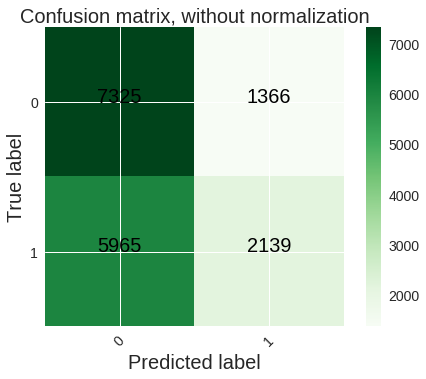

In [36]:
cnf_matrix = confusion_matrix((dp_test>0).astype(np.int), (dp_predict>0).astype(np.int))
fig = visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], fontsize = 20, normalize = False, title='Confusion matrix, without normalization', cmap = plt.cm.Greens)
plt.show()


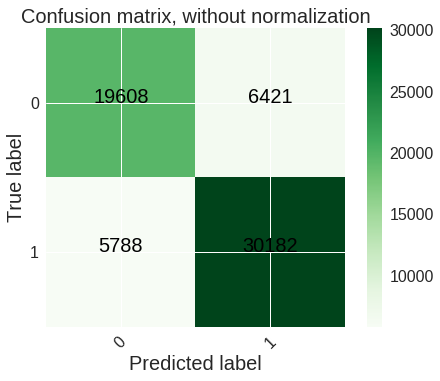

In [39]:
cnf_matrix = confusion_matrix((dp_train>0).astype(np.int), (clf.predict(s_train)>0).astype(np.int))
fig = visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], fontsize = 20, tick_fontsize = 16, cmap = plt.cm.Greens, title='Confusion matrix, without normalization')
plt.show()

### For correctly predicted winners, what are typical values of dprice? Also plot distribution of dprice_test when winner is predicted but it's actually a loser on same axes.

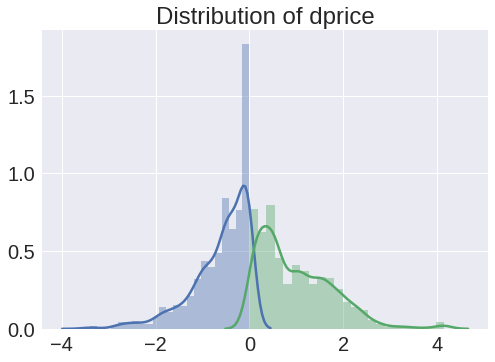

In [95]:
I2 = (dp_test > 0) & (dp_predict > 0)
dp_slice_winner = dp_test[I2]
dp_slice_loser = dp_test[(dp_test < 0) & (dp_predict > 0)]
#print dp_slice_loser.min(), dp_slice_loser.max(), dp_slice_loser.mean()
ax1 = sns.distplot(dp_slice_loser.values)
ax2 = sns.distplot(dp_slice_winner.values)
ax2.set_title('Distribution of dprice')
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
plt.show()

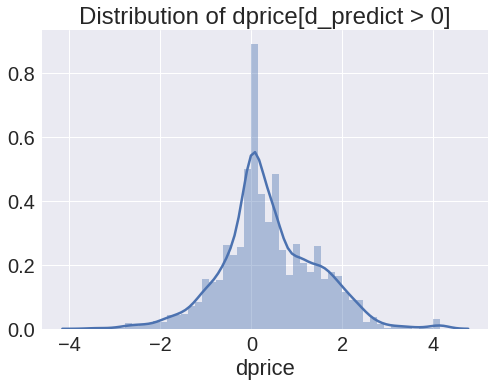

0.392461055635 1.04502861857


In [100]:
dp_predict_winner_density = dp_test[dp_predict > 0]
ax = sns.distplot(dp_predict_winner_density)
#ax.set_xlabel('dprice', fontsize = 20)
ax.set_title('Distribution of dprice[d_predict > 0]')
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
plt.show()
print dp_predict_winner_density.mean(), dp_predict_winner_density.std()

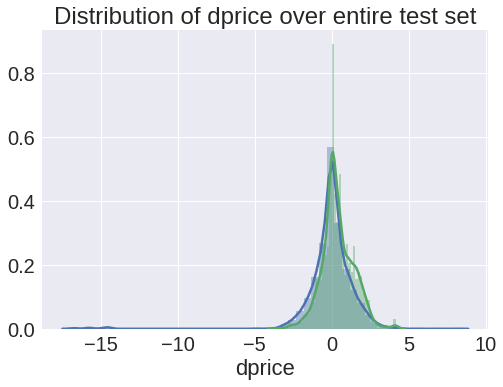

-0.050765525454 1.65736986126


In [102]:
ax1 = sns.distplot(dp_test)
ax2 = sns.distplot(dp_predict_winner_density)
ax1.set_title('Distribution of dprice over entire test set')
#sns.distplot(dp_predict_winner_density)
plt.show()
print dp_test.mean(), dp_test.std()

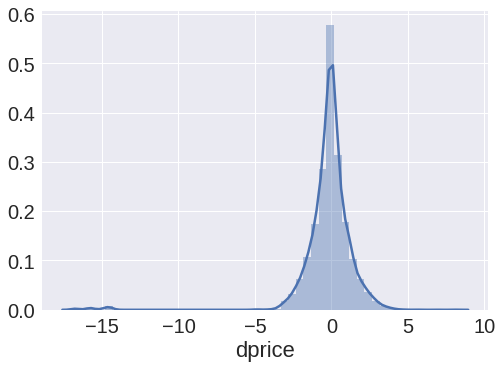

-0.1676586155 1.76576672672


In [103]:
#distribution of dprice when dp_predict < 0
dp_predict_loser_density = dp_test[dp_predict < 0]
sns.distplot(dp_predict_loser_density)
plt.show()
print dp_predict_loser_density.mean(), dp_predict_loser_density.std()

In [105]:
print dp_test.mean(), dp_test.std()
print dp_train.mean(), dp_train.std()

-0.050765525454 1.65736986126
0.251807142051 1.05489608799


### Expected gains

In [106]:
I3 = dp_predict > 0
E = np.sum(dp_test[I3])/np.sum(I3)
print E

0.392461055635


In [107]:
#clf.best_estimator_.feature_importances_[:20]
clf.feature_importances_[:20]

array([  8.67601931e-02,   4.03860117e-01,   1.20003426e-01,
         4.36566299e-02,   1.01096667e-01,   2.39937164e-02,
         1.48120294e-03,   3.01850899e-06,   2.49280981e-04,
         3.23610197e-06,   3.24851416e-03,   1.79761376e-04,
         1.85272171e-03,   6.90822372e-05,   1.09882801e-04,
         1.72714362e-03,   6.46722580e-04,   2.41710428e-05,
         1.30167930e-04,   9.98120718e-06])

In [108]:
#important_features_indices = np.where(clf.best_estimator_.feature_importances_ > 0.01)
#ordered_indices = sorted(range(s.shape[1]), key=clf.best_estimator_.feature_importances_.__getitem__)
important_features_indices = np.where(clf.feature_importances_ > 0.001)
ordered_indices = sorted(range(s_train.shape[1]), key=clf.feature_importances_.__getitem__)
ordered_indices.reverse()
ordered_indices[:20]

[1,
 2,
 4,
 0,
 3,
 5,
 265,
 36,
 263,
 66,
 305,
 75,
 371,
 342,
 77,
 74,
 10,
 273,
 290,
 65]

In [110]:
for w in list(s_train.columns[ordered_indices[:20]]):
    print w.upper()

YIELD
TRADEDATE
MATURITY
HOLDTIME
COUPON
RTG
STWD
NEW JERSEY
CMNTYS
ISSUE SOURCE: APPROPRIATIONS
REF
ISSUE SOURCE: GOVT. FD./GRANT REV.
ST
SWR
ISSUE SOURCE: HLTH, HOSP, NURSHOME REV.
ISSUE SOURCE: GENERAL FUND
CALIFORNIA
AUTH
EL
ISSUE SOURCE: AD VALOREM PROPERTY TAX


In [64]:
#clf.best_estimator_.feature_importances_[ordered_indices[:20]]
clf.feature_importances_[ordered_indices[:20]]

array([ 0.40407752,  0.12045415,  0.10076672,  0.0861519 ,  0.04279848,
        0.02316493,  0.01666474,  0.01627966,  0.01539632,  0.01512607,
        0.00897266,  0.00508616,  0.00469607,  0.00440517,  0.00414884,
        0.00385342,  0.00362448,  0.00298066,  0.00293387,  0.0028853 ])

In [111]:
clf_dec = DecisionTreeRegressor()
t0 = time.time()
clf_dec.fit(s_train, dp_train)
print time.time() - t0

0.710606813431


In [112]:
dp_predict_dec = clf_dec.predict(s_test)

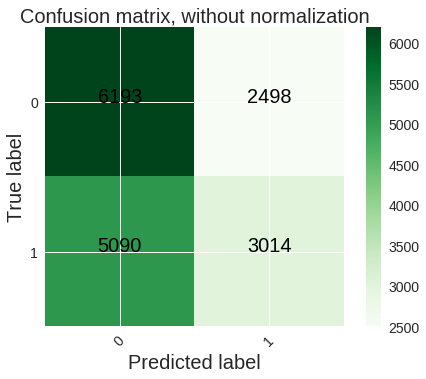

In [113]:
cnf_matrix = confusion_matrix((dp_test>0).astype(np.int), (dp_predict_dec>0).astype(np.int))
fig = visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], fontsize = 20, normalize = False, title='Confusion matrix, without normalization', cmap = plt.cm.Greens)
plt.show()

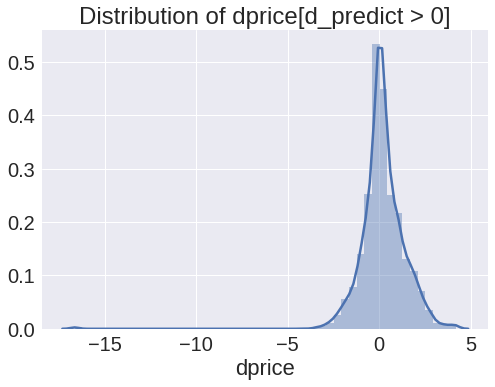

0.202126814224 1.26038631121


In [114]:
dp_predict_dec_winner_density = dp_test[dp_predict_dec > 0]
ax = sns.distplot(dp_predict_dec_winner_density)
#ax.set_xlabel('dprice', fontsize = 20)
ax.set_title('Distribution of dprice[d_predict > 0]')
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
plt.show()
print dp_predict_dec_winner_density.mean(), dp_predict_dec_winner_density.std()

In [115]:
tree.export_graphviz(clf_dec, 'dprice_decision_tree.dot', max_depth = 5, filled = True, feature_names = list(s_test.columns))